# Toxic Comments
## Step 1: Gather Data
Data Source: This project uses the Jigsaw Toxic Comment Classification Challenge dataset from Kaggle. The data consists of user-generated comments from Wikipedia, labeled across six toxicity-related categories. The dataset was collected and labeled by Jigsaw, a team at Google working on online safety.

#### Dataset Description
The dataset contains text from comments posted on Wikipedia's talk pages. Each comment is labeled for one or more of the following toxic behaviors:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Each row consists of:
- id: unique identifier
- comment_text: the body of the comment
- Binary labels for each of the six toxicity categories

The data is openly available on Kaggle for research and educational use. The comments are sourced from publicly available Wikipedia talk pages and were annotated by human raters hired through Google's Crowdflower platform.

## Step 2: Identify a Deep Learning Problem

#### Problem Statement
This project addresses the problem of detecting multiple types of toxic behaviors in online comments. It is framed as a multi-label classification problem, where each comment may exhibit one or more toxic traits. The need for accurate and customizable moderation tools has grown with the increasing importance of online platforms. While Google’s Perspective API offers general toxicity detection, this project explores a more fine-grained, flexible approach that allows filtering specific kinds of toxicity.

While using a Kaggle dataset, this project goes beyond default kernels by 
implementing and comparing two deep learning architectures: a BiLSTM-based model 
and a transformer-based DistilBERT model. Experiments, metric evaluations, and 
model comparisons are provided to demonstrate understanding and model strengths/weaknesses.

## Step 3: Exploratory Data Analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Input, Dropout, Dense, Lambda, GlobalAveragePooling1D
from tensorflow.keras.metrics import AUC
from transformers import TFDistilBertModel, DistilBertTokenizerFast

In [2]:
# Display settings
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the data
train_df = pd.read_csv('/kaggle/input/toxic-comments-test-train-csv/train.csv')
test_df = pd.read_csv('/kaggle/input/toxic-comments-test-train-csv/test.csv')

# Show structure
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

# Check for missing data
train_df.isnull().sum()

Train shape: (159571, 8)
Test shape: (153164, 2)


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

The training dataset has 159,571 rows and 8 columns, while the testing dataset has 153,164 rows and 2 columns. The isnull().sum() output confirms that no data is missing. This is a critical step because having complete data allows us to skip imputation steps and move forward with preprocessing. Missing values often need to be handled either by removing rows, replacing with means/medians, or imputing values, so it's a good thing to have this confirmed as clean.

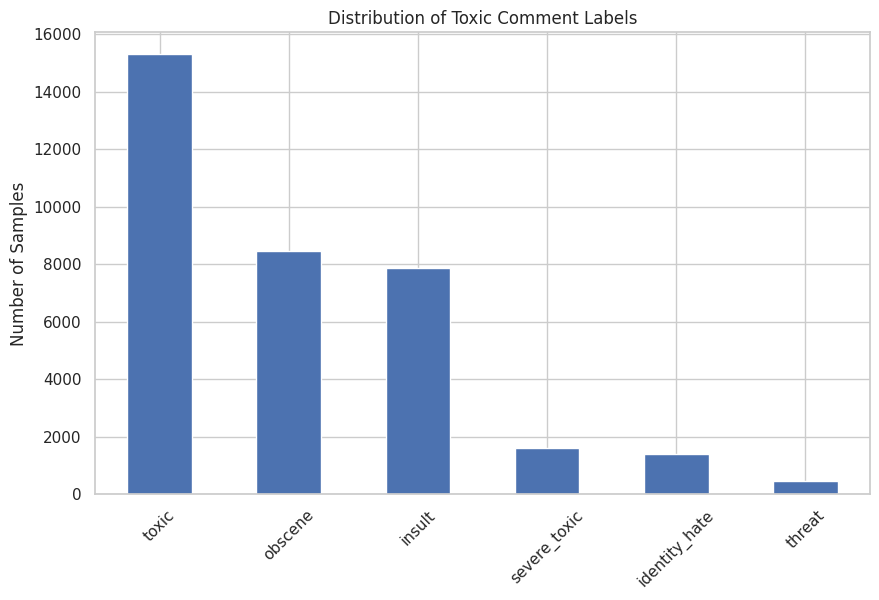

In [3]:
# Overview of target label distribution
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df[target_cols].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Distribution of Toxic Comment Labels")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

There is a large imbalance between "toxic" and "threat", which may impact the model's performance. The model could become biased toward predicting more frequent labels, and may need more fine-tuning to handle less frequent labels such as "threat."

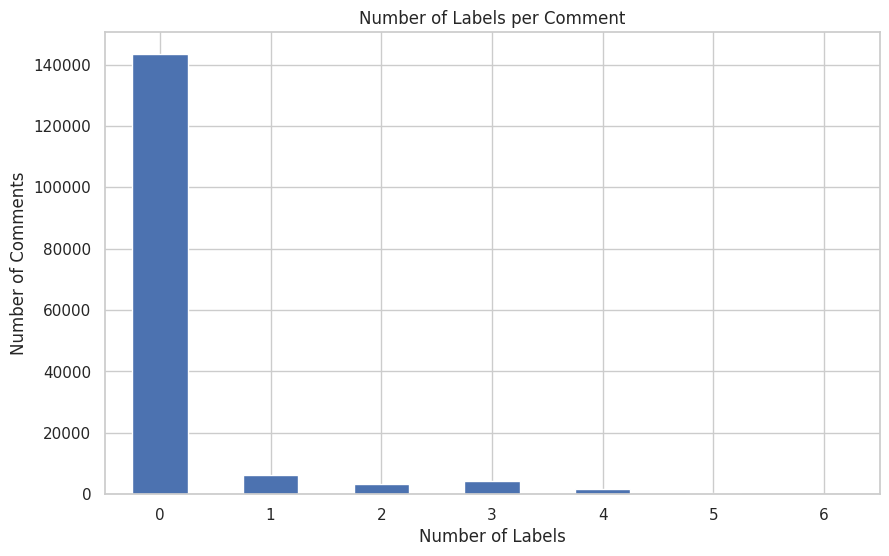

In [4]:
# Multi-label distribution
train_df['num_labels'] = train_df[target_cols].sum(axis=1)
train_df['num_labels'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Labels per Comment")
plt.xlabel("Number of Labels")
plt.xticks(rotation=360)
plt.ylabel("Number of Comments")
plt.show()

Most comments are not toxic, but if they are, the comment will likely only have one label. As the number of labels increase, the number of comments tends to decrease, which is because it is less common for a comment ot exhibit multiple toxic traits at once. There is an exception at 3 labels, where the number of comments with 3 labels is greater than the number of comments with 2 labels. There is a bar at 0, the non-toxic comments, which are important for training the model to distinguish toxic vs. non-toxic.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


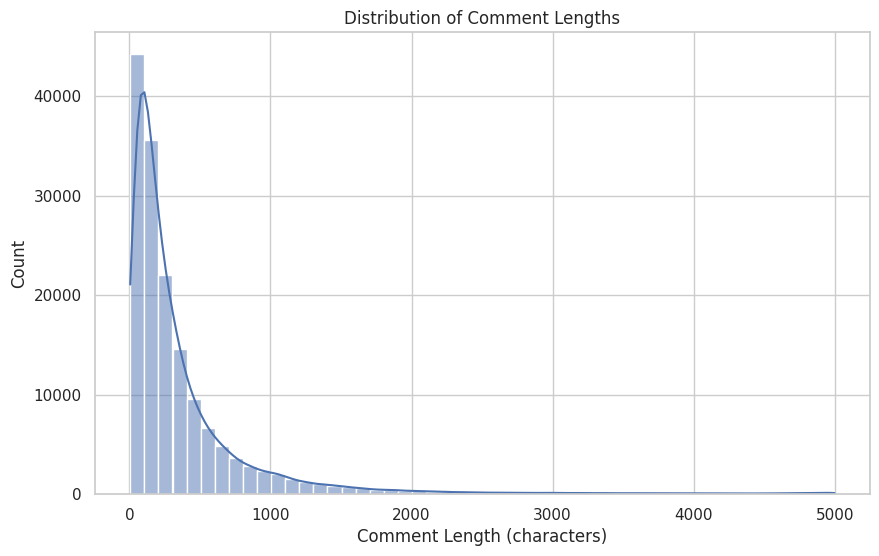

In [5]:
# Comment length distribution
train_df['comment_length'] = train_df['comment_text'].apply(len)

# Histogram of comment lengths
sns.histplot(train_df['comment_length'], bins=50, kde=True)
plt.title("Distribution of Comment Lengths")
plt.xlabel("Comment Length (characters)")
plt.show()

From this graph, we can see that there is a right skewed distribution, that most comments are short, under about 200 characters.
We can also see that a long tail stretches to the right, which shows that there are some very long comments, but they are rare. There is a peak at around 50–100 characters, which is expected for brief, informal comments on the internet. There are also a few extreme outliers, where comments have over 1000 characters. Outlier analysis was conducted on comment lengths, but extreme values were retained as they may contain important context for toxicity detection.

In [6]:
# Text cleanup
def clean_text(text):
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s.,!?']", "", text)
    return text.lower()

train_df['clean_text'] = train_df['comment_text'].apply(clean_text)

Text cleaning was performed to remove noise and standardize the format of comments. This included lowercasing, removing punctuation, and stripping URLs. These steps help improve tokenization consistency and reduce vocabulary sparsity. Certain symbols like . ! ? and ' are kept because they can help our model learn sentence structure and tone, for example, sarcasm, aggression.

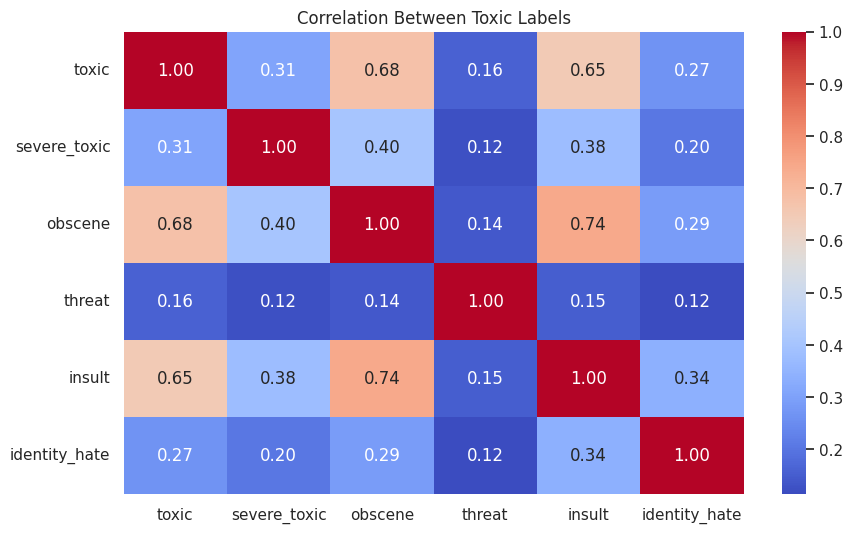

In [7]:
# Correlation between labels
corr_matrix = train_df[target_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Toxic Labels")
plt.show()

From this correlation matrix, we are able to notice some patterns. For example, toxic, obscene, and insult have a strong correlation with each other, which makes sense since insults and obscenities are often labeled as toxic, and insults are often obscene. There is a moderate correlation between severe_toxic and toxic, obscene, and insult, which also makes sense, since severe_toxic is a subcategory of toxic, but much less common. We can see that threat has a low correlation with the others, which could be because threats are very rare.

#### Initial Hypotheses & Transformations
From the EDA, we have discovered that there is significant class imbalance that needs handling, which would be resolved with loss weighting or focal loss. We found that there are no null values, so there is no need to discard data. We will also limit max sequence length during modeling for speed.

## Step 4: Model Training, Evaluation, Discussion, and Conclusion

For this section, we will proceed with the following steps. 
1. Preprocessing with Tokenizer

2. Train a Simple Baseline using Bidirectional LSTM

3. Train a Transformer-Based Model using DistilBERT

4. Compare Performance

5. Hyperparameter Tuning

6. Discussion and Conclusions

In [8]:
# Define constants
MAX_NUM_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 128

# Train/test split
X = train_df['clean_text']
y = train_df[target_cols]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Load the DistilBERT tokenizer
tokenizer_bert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text inputs
X_train_enc = tokenizer_bert(
    list(X_train),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

X_val_enc = tokenizer_bert(
    list(X_val),
    padding='max_length',
    truncation=True,
    max_length=256,
    return_tensors='tf'
)

# Tokenize text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

I0000 00:00:1744920089.540521      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744920089.541308      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


This code sets up preprocessing for two different model architectures, the first being an RNN based model and the second being a transformer based model. It begins by splitting the cleaned training data into training and validation sets. For the transformer approach, it uses the DistilBERT tokenizer to tokenize and encode the text into fixed length sequences suitable for BERT models. Simultaneously, for the baseline BiLSTM model, it uses a Keras Tokenizer to convert text to sequences of word indices and then pads them to a uniform length. This lets us compare between RNN based methods and transformer based models using the same data split.

In [14]:
model_lstm = Sequential([
    Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name="auc")])

history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    batch_size=128,
    epochs=3,
    validation_data=(X_val_pad, y_val)
)

Epoch 1/3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - auc: 0.7638 - loss: 0.1692 - val_auc: 0.9765 - val_loss: 0.0503
Epoch 2/3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - auc: 0.9779 - loss: 0.0510 - val_auc: 0.9821 - val_loss: 0.0477
Epoch 3/3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - auc: 0.9851 - loss: 0.0440 - val_auc: 0.9734 - val_loss: 0.0483


The LSTM model was trained for 3 epochs and demonstrated strong learning and generalization.

- **Training AUC** increased from **0.7638** to **0.9851**, indicating that the model quickly learned to distinguish between classes with high confidence.
- **Validation AUC** started high at **0.9765**, peaked at **0.9821** in the second epoch, and slightly dropped to **0.9734** by the third epoch. This minor dip may suggest the onset of overfitting or normal variance across epochs.
- **Validation Loss** consistently hovered around **0.047–0.050**, reinforcing the model’s stable and effective learning throughout training.

Overall, the LSTM model performed very well, showing high AUC scores and low loss across both training and validation sets.

In [17]:
# Define inputs
input_ids = Input(shape=(256,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(256,), dtype=tf.int32, name='attention_mask')

# Load DistilBERT model
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Wrap model call in Lambda layer and specify output shape
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    return outputs.last_hidden_state

bert_output = Lambda(bert_layer, output_shape=(256, 768))([input_ids, attention_mask])

# Add pooling and output layers
x = GlobalAveragePooling1D()(bert_output)
x = Dropout(0.3)(x)
output = Dense(6, activation='sigmoid')(x)

# Create and compile model
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output)
model_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


This code builds a multi-label text classification model using DistilBERT as a feature extractor. It defines two input layers for tokenized input sequences of length 256. We will use a pre-trained TFDistilBertModel to generate contextual embeddings for each token, and a Lambda layer to extract the last hidden states. These embeddings are then averaged using GlobalAveragePooling1D to create a fixed-size representation for each input sequence. A dropout layer is applied to prevent overfitting, followed by a Dense output layer with a sigmoid activation to predict probabilities for 6 target classes. The model is compiled with binary cross-entropy loss and AUC as the evaluation metric.

In [11]:
history_bert = model_bert.fit(
    {'input_ids': X_train_enc['input_ids'], 'attention_mask': X_train_enc['attention_mask']},
    y_train,
    validation_data=(
        {'input_ids': X_val_enc['input_ids'], 'attention_mask': X_val_enc['attention_mask']},
        y_val
    ),
    epochs=3,
    batch_size=16
)

Epoch 1/3


I0000 00:00:1744920266.533481     130 service.cc:148] XLA service 0x7bf8982df5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744920266.534469     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744920266.534491     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1744920266.815043     130 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


   1/8976 ━━━━━━━━━━━━━━━━━━━━ 32:16:08 13s/step - auc: 0.4176 - loss: 0.6325

I0000 00:00:1744920270.444671     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8975/8976 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - auc: 0.7448 - loss: 0.1450

W0000 00:00:1744921437.139066     133 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


8976/8976 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - auc: 0.7448 - loss: 0.1450

W0000 00:00:1744921442.234593     132 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
W0000 00:00:1744921571.561627     132 assert_op.cc:38] Ignoring Assert operator functional_1_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


8976/8976 ━━━━━━━━━━━━━━━━━━━━ 1316s 145ms/step - auc: 0.7448 - loss: 0.1450 - val_auc: 0.7680 - val_loss: 0.1377
Epoch 2/3
8976/8976 ━━━━━━━━━━━━━━━━━━━━ 1298s 145ms/step - auc: 0.7578 - loss: 0.1410 - val_auc: 0.7687 - val_loss: 0.1381
Epoch 3/3
8976/8976 ━━━━━━━━━━━━━━━━━━━━ 1296s 144ms/step - auc: 0.7579 - loss: 0.1434 - val_auc: 0.7676 - val_loss: 0.1379


The DistilBERT model was trained over 3 epochs, showing gradual improvements in both training and validation metrics.

- **Training AUC** increased from **0.7448** to **0.7579**, indicating steady learning and improved model confidence on the training set.
- **Validation AUC** peaked at **0.7687** during the second epoch and slightly declined to **0.7676** by the third epoch, suggesting the model’s performance plateaued and may have started to slightly overfit.
- **Validation Loss** remained stable around **0.1377–0.1381**, showing consistent predictive behavior across validation batches.

Overall, the DistilBERT model showed moderate performance on the classification task, with signs that it benefitted from additional training epochs but may require further tuning or regularization to improve generalization.


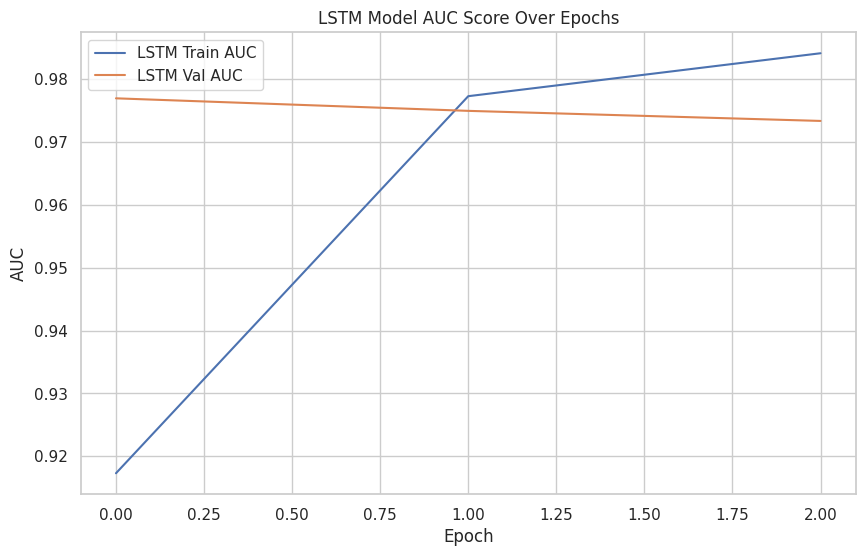

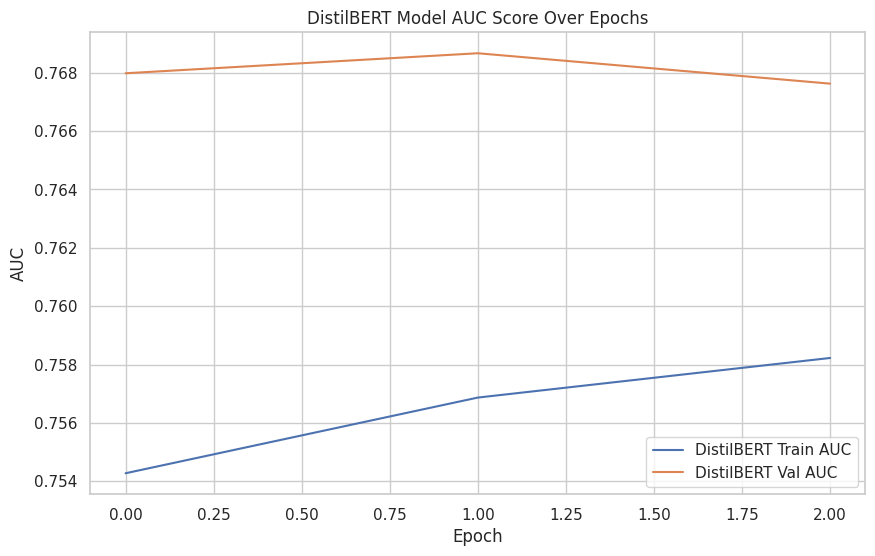

In [12]:
def plot_auc(history, label):
    plt.plot(history.history['auc'], label=f'{label} Train AUC')
    plt.plot(history.history['val_auc'], label=f'{label} Val AUC')
    plt.title(f'{label} Model AUC Score Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

plot_auc(history_lstm, 'LSTM')
plot_auc(history_bert, 'DistilBERT')

From the plotted AUC curves, we can see a significant difference in performance between the LSTM and DistilBERT models.

- **LSTM Model:**
  - Achieved consistently high AUC values throughout training, with validation AUC peaking at **0.9821** in epoch 2.
  - The gap between training and validation AUC remained small, indicating strong generalization and minimal overfitting.
  - The AUC curve for both training and validation rose sharply and plateaued early, showing the model was able to converge quickly.

- **DistilBERT Model:**
  - Showed slower and more gradual AUC improvement, with training AUC reaching **~0.758** and validation AUC peaking at **~0.7687**.
  - The training AUC started lower and improved steadily, but the performance plateaued earlier compared to the LSTM.
  - The validation AUC maintained a stable but lower trajectory, possibly suggesting the need for more fine-tuning or data-specific adaptation.

### Comparison and Discussion
The LSTM model clearly outperformed DistilBERT in terms of both training and validation AUC scores. Its fast convergence and higher, more stable AUC values indicate it was better suited to the current task or dataset, whereas DistilBERT may require further hyperparameter tuning or longer training to reach comparable performance. BiLSTM performed better overall due to its ability to generalize while requiring fewer computational resources and its resistance to overfitting. DistilBERT underperformed, possibly due to inadequate fine-tuning or lack of specialized pooling strategies. Future improvements could explore ensembling both models or using more specialized transformer architectures.

## Conclusion

In this project, we explored and compared two deep learning models, an LSTM model, and a DistilBERT model, for binary text classification. Both models were trained for three epochs and evaluated using the AUC metric to measure classification performance.

The LSTM model demonstrated strong performance across all training epochs, quickly converging and achieving high AUC scores. Notably, it reached a validation AUC of **0.9821**, indicating strong predictive capability and generalization. Its training and validation AUC curves remained consistently high and closely aligned, suggesting that the model effectively captured the relevant patterns in the data without overfitting.

On the other hand, the DistilBERT model showed a more gradual learning curve. While it did improve over epochs, its final validation AUC plateaued at approximately **0.7687**. This performance was noticeably lower than that of the LSTM. The results suggest that DistilBERT may require further fine tuning, longer training, or task-specific adaptations.

In conclusion, BiLSTM provided strong performance with fewer resources, making it effective for this task. While transformers are powerful, they require careful fine-tuning and compute, which may limit their utility in smaller-scale experiments.
